In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [2]:
#Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Directory where the images are stored
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
# Function to load and resize images
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)  # Open the image file
        image = image.resize(target_size)  # Resize the image to the target size
        return np.array(image) / 255.0  # Convert to a NumPy array and normalize
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [5]:
# Load training group IDs from a text file
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [6]:
# Load validation group IDs from a text file
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [7]:
%%capture
# Lists to store image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Error loading JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"Sample ID missing in JSON: {json_path}")
            continue
        
        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Image file not found: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Key 'classes' missing or empty in JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [8]:
# Check the number of images uploaded
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [9]:
# Separate images and labels
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [10]:
#load images
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [11]:
# Check if an image has failed to load
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [12]:
# Convert the labels to the appropriate format (numeric)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [13]:
# One-Hot Encoding of labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [14]:
# Load the VGG16 base model with pre-trained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [15]:
# Freeze VGG16 layers to train only customised layers
base_model.trainable = False

In [16]:
# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [17]:
# creste the final model 
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Fine-tuning 
# Defrost the last layers of VGG16 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [19]:
# recompile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [26]:
# train the model with fine-tuning
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
21/21 [==============================] - 72s 3s/step - loss: 1.0339 - accuracy: 0.4829 - val_loss: 0.8574 - val_accuracy: 0.7009
Epoch 2/20
21/21 [==============================] - 66s 3s/step - loss: 0.9095 - accuracy: 0.5857 - val_loss: 0.7612 - val_accuracy: 0.7757
Epoch 3/20
21/21 [==============================] - 69s 3s/step - loss: 0.7771 - accuracy: 0.7212 - val_loss: 0.7367 - val_accuracy: 0.7430
Epoch 4/20
21/21 [==============================] - 66s 3s/step - loss: 0.7044 - accuracy: 0.7383 - val_loss: 0.6329 - val_accuracy: 0.7523
Epoch 5/20
21/21 [==============================] - 66s 3s/step - loss: 0.6171 - accuracy: 0.7913 - val_loss: 0.5830 - val_accuracy: 0.7570
Epoch 6/20
21/21 [==============================] - 66s 3s/step - loss: 0.5487 - accuracy: 0.8162 - val_loss: 0.7411 - val_accuracy: 0.7196
Epoch 7/20
21/21 [==============================] - 66s 3s/step - loss: 0.5656 - accuracy: 0.8131 - val_loss: 0.4945 - val_accuracy: 0.8131
Epoch 8/20
21/21 [==

In [27]:
# save the model 
model.save('trained_model.vgg16_vague_resolution')

INFO:tensorflow:Assets written to: trained_model.vgg16_vague_resolution\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_vague_resolution\assets


In [28]:
# Evaluate the model using the validation data generator
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 6s 849ms/step - loss: 0.3553 - accuracy: 0.8645
Loss no conjunto de validação: 0.35527053475379944
Accuracy no conjunto de validação: 0.8644859790802002


In [29]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions from the model
val_predictions = model.predict(np.array(val_images))

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Classification report
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=label_encoder.classes_)
print("Relatório de Classificação:")
print(class_report)

7/7 [==============================] - 6s 891ms/step
Matriz de Confusão:
[[95  6  0]
 [ 2 90  1]
 [ 2 18  0]]
Relatório de Classificação:
              precision    recall  f1-score   support

      E.coli       0.96      0.94      0.95       101
P.aeruginosa       0.79      0.97      0.87        93
    S.aureus       0.00      0.00      0.00        20

    accuracy                           0.86       214
   macro avg       0.58      0.64      0.61       214
weighted avg       0.80      0.86      0.83       214



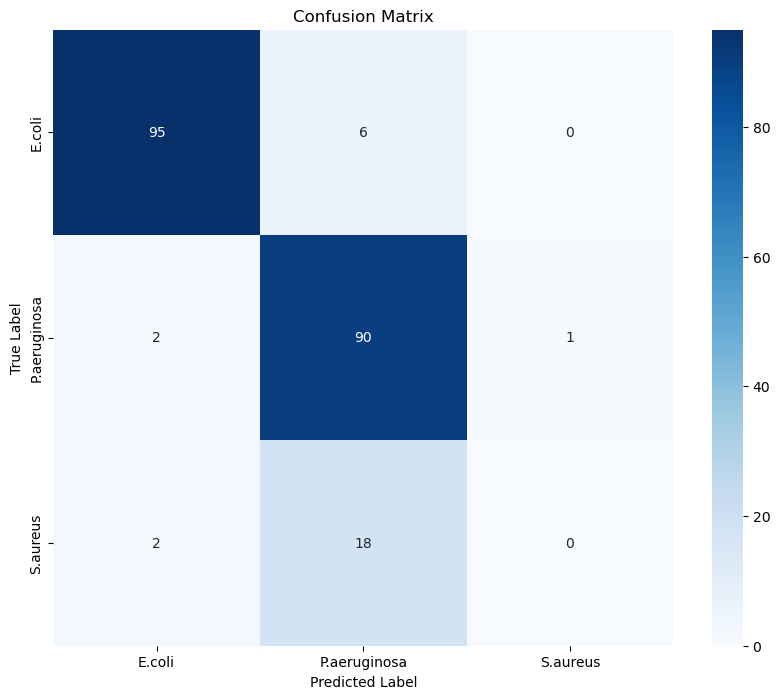

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

val_predictions = model.predict(np.array(val_images))
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

7/7 [==============================] - 6s 859ms/step


C:\Users\bruna\AppData\Local\Temp\ipykernel_20724\3111837272.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


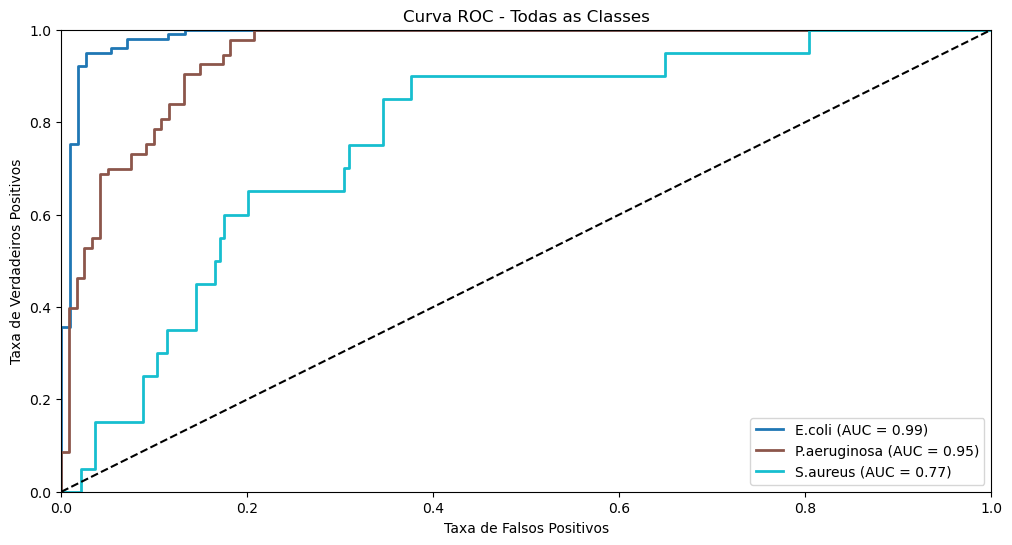

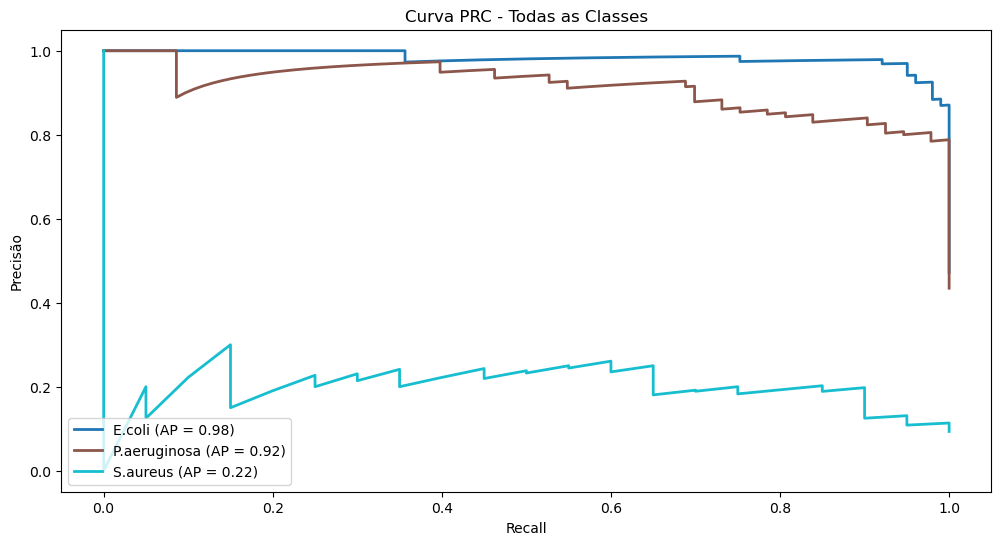

In [32]:
# Prepare the data for ROC and PRC
num_classes = len(label_encoder.classes_)
colors = plt.cm.get_cmap('tab10', num_classes)

# ROC curve
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(val_labels_labels == i, val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i), lw=2, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Todas as Classes')
plt.legend(loc='lower right')
plt.show()

# PRC curve
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels_labels == i, val_predictions[:, i])
    ap = average_precision_score(val_labels_labels == i, val_predictions[:, i])
    plt.plot(recall, precision, color=colors(i), lw=2, label=f'{label_encoder.classes_[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva PRC - Todas as Classes')
plt.legend(loc='lower left')
plt.show()